# 图像卷积
以图像卷积为例，看一看卷积层的应用

## 互相关运算
首先暂时忽略通道（第三维）这一情况，看看如何处理二维图像数据和隐藏表示。

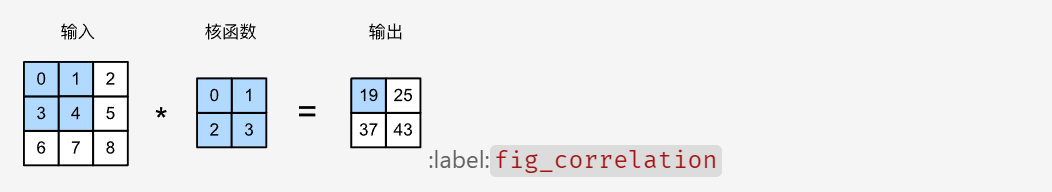

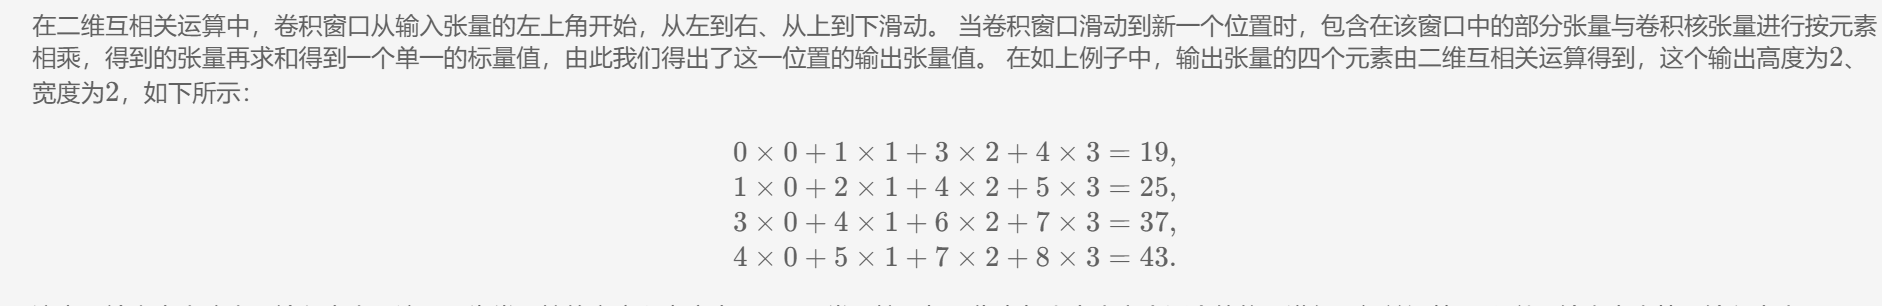

输出大小等于输入大小$n_h \times n_w$减去卷积核的大小$k_h \times k_w$，即
$$
    (n_h - k_h + 1) \times (n_w - k_w + 1)
$$
我们可以通过在图像边界周围填充零来保证有足够的空间移动卷积核，从而保持输出大小不变。接下来，我们在`corr2d`函数中实现如上过程，该函数接受输入张量`X`和卷积核张量`K`，并返回输出张量`Y`.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X, K):
    """计算二维互关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

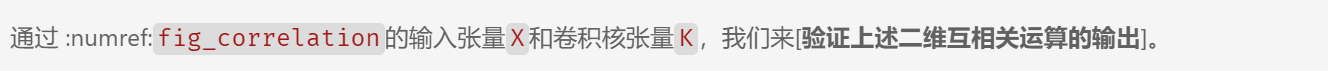

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 卷积层
卷积层付输入和卷积核权重进行互相关计算，并在添加标量偏置之后产生输出。所以，卷积层中的两个呗训练的参数是卷积核权重和标量偏置。就像我们之前随机初始化全连接层一样，在训练基于卷积层的模型时，我们也随机初始化卷积核权重。
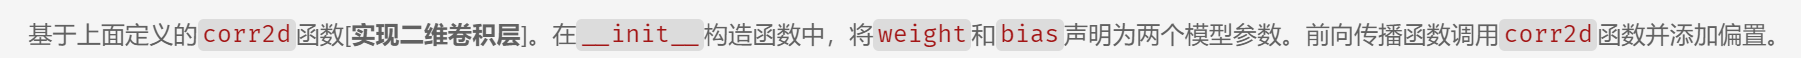

In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

高度和宽度分别是$h$和$w$的卷积核可以被称为$h \times w$卷积或$h \times w$卷积核。我们也将带有$h \times w$卷积核的卷积层称为$h \times w$卷积层。}

## 图像中目标的边缘检测
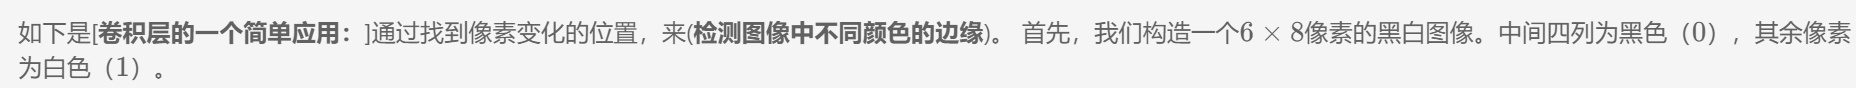

In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

接下来构造一个高度为1，宽度为2的卷积核`K`。当进行互相关计算的时候，如果相邻的两元素相同，则输出为0，否则输出为非零

In [6]:
K = torch.tensor([[1.0, -1.0]])

现在，我们对参数`X`（输入）和`K`（卷积核）执行互相关运算。如下所示，**[输出`Y`中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘]**，其他情况输出为0。

In [7]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

现在将输入的二维图像转置，再进行如上的互相关计算，其输出如下，之前检测到的垂直边缘消失了。不出所料，这个卷积核`K`只可以检测垂直边缘，无法检测水平边缘。

In [9]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 学习卷积核
如果我们只需要寻找黑白边缘，那么以上`[1, -1]`的边缘检测器足以。然而，当有了更复杂的数值卷积核，或者连续的卷积层时，我们不可能手动设计滤波器。那么是否可以**学习由`X`生成`Y`的卷积核呢**？

现在让我们看看是否可以通过仅查看`输入-输出`对来学习由`X`生成`Y`的卷积核。

先构造一个卷积层，并将其卷积核初始化为随机张量。接下来，在每次迭代中，比较`Y`与卷积层输出的平方误差，然后计算梯度来更新卷积核。为了简单起见，这里使用内置的二维卷积层，并忽略偏置。

In [11]:
# 构造一个二维卷积层，它具有1个输出通道和形状为(1,2)的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小，通道，高度，宽度），
# 其中的批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2 # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 4.227
epoch 4, loss 0.923
epoch 6, loss 0.242
epoch 8, loss 0.076
epoch 10, loss 0.027


现在来看一看学习到的卷积核的权重张量。

In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0068, -0.9742]])

学习到的卷积和权重非常接近我们之间定义的卷积核`K`

## 互相关和卷积

相差无几，术语通用

## 特征映射和感受野
输出的卷积层有时候被称之为特征映射，因为它可以被视为一个输出映射到下一层的空间维度的转换器。在卷积神经网络中，对于某一层的任意元素 $x$ ，其感受野是指在前向传播期间可能影响$x$计算的所有元素（来自所有先前层）。



请注意，感受野可能大于输入的实际大小。举个例子：给定 $2 \times 2$ 卷积核，阴影输出元素值19的感受野是输入阴影部分的四个元素。假设之前的输出为 $Y$ ，其大小为 $2 \times 2$， 现在我们在其后附加一个卷积层，该卷积层以$Y$为输入，输出单个元素$z$。在这种情况下，$Y$ 上的$z$的感受野包括$Y$的所有四个元素，而输入的感受野包括最初的所有九个输入元素。因此，当一个特征图中的任意元素需要检测更广区域的输入特征时，我们可以构建一个更深的网络。

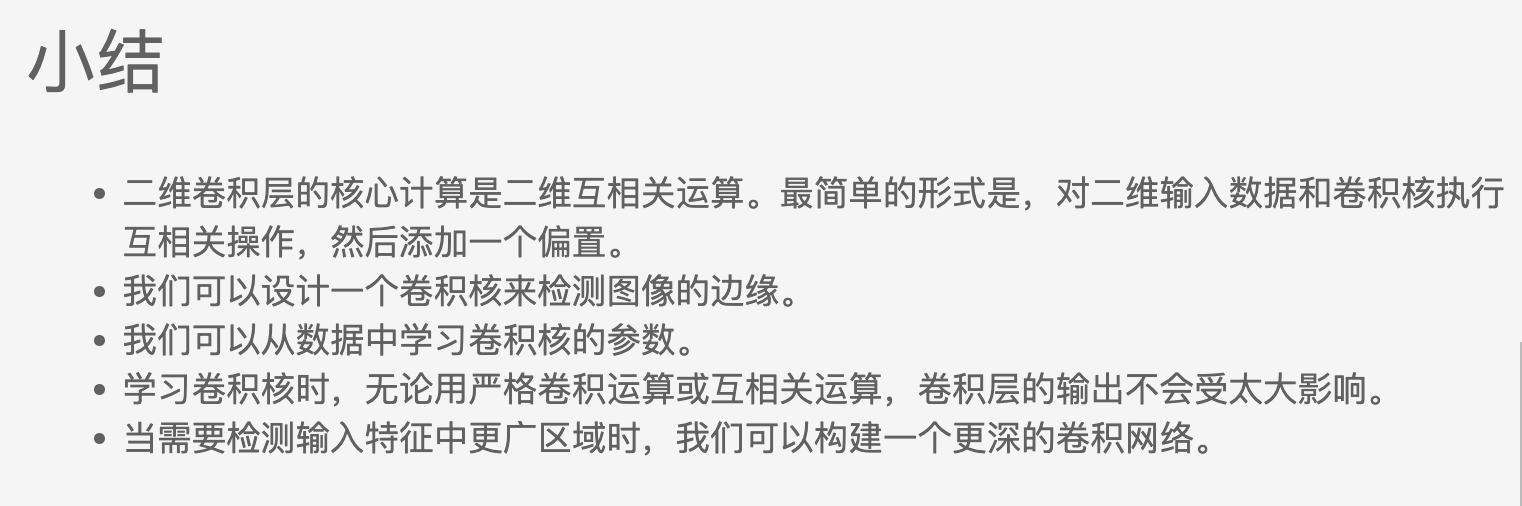

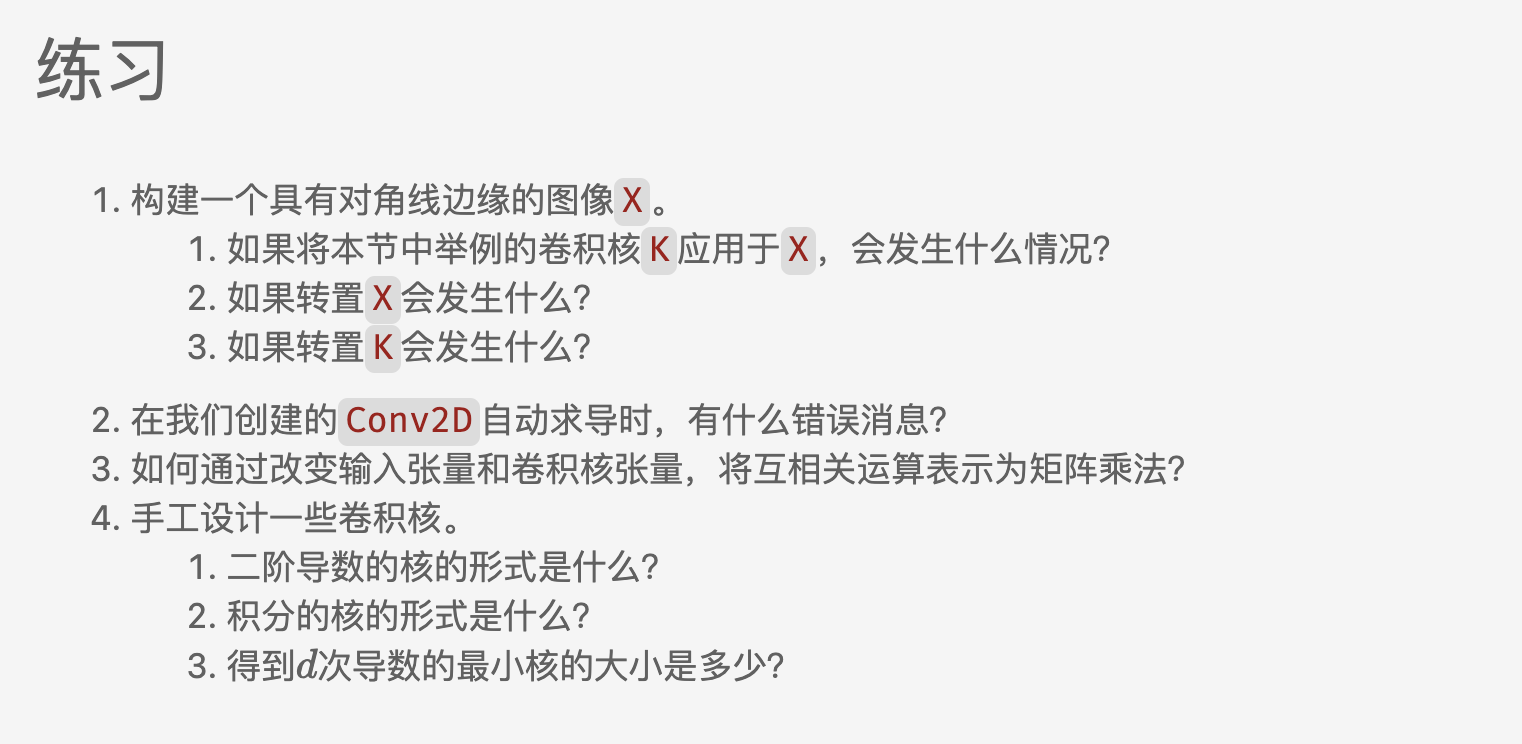